# Projections and uncertainties of future winter windstorm damage in Europe 
## Notebook 2: Damage Calculation
This notebook compute the damages projections of the publication Projections and uncertainties of future winter windstorm damage in Europe. The hazard data must be pre-processed beforehand using the notebook 1. The CLIMADA package needs to be installed. See tutorial on https://github.com/CLIMADA-project/climada_python/blob/main/doc/guide/Guide_Installation.ipynb for guidance to install CLIMADA. See tutorial https://github.com/CLIMADA-project/climada_python/blob/main/doc/tutorial/1_main_climada.ipynb for guidance to use CLIMADA. Exposure data is loaded using LitPop (see tutorial https://github.com/CLIMADA-project/climada_python/blob/main/doc/tutorial/climada_entity_LitPop.ipynb).

In [4]:
import matplotlib.pyplot as plt
#import xarray as xr
import numpy as np
#import copy as cp
import pandas as pd
from scipy import sparse
import cartopy.crs as ccrs
from timeit import default_timer as timer
from os import mkdir, remove, rmdir

from climada.engine import Impact, ImpactCalc
from climada.entity import ImpactFunc,ImpactFuncSet

import warnings
warnings.filterwarnings('ignore') #Ignore warnings for making the tutorial's pdf.
warnings.simplefilter('ignore')
import logging
from climada.util.config import LOGGER
LOGGER.setLevel(logging.ERROR) #Ignore CLIMADA warnings for making the tutorial's pdf.

In [5]:
##custom function definition
from SL_bias_corr import *
from constants import *
from functions_projUncWS import *
idx = pd.IndexSlice

In [6]:
#setup folders and folder variables.
# All these variables need to be defined correctly for the code to work.
# The strings in these variables should point to existing folders on your computer.
project_folder = '/Users/lseverino/Documents/Publi MT/Model code Proj.-unc.-WS-damage'
data_folder = project_folder+'/data/' #this folder will contain the netcdf files downloaded by this script
results_folder = project_folder+'/results/' #this folder will contain results (e.g. climada impact data)
                                                            # produced by this script
file_identifier = '_v01' # this string is added to all files written by this code

In [7]:
#plotting params
import matplotlib as mpl
import matplotlib.colors as mcolors
#plt.style.use('tableau-colorblind10')
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = MEDIUM_SIZE
mpl.rcParams['axes.titlelocation'] = 'left'
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE
mpl.rcParams['legend.fontsize'] = SMALL_SIZE
tab_cols = mcolors.TABLEAU_COLORS
clist = mpl.rcParams['axes.prop_cycle']

## Prepare exposure data
LitPop data needs to be downloaded for each countries and for each parameterization. A .csv file for the metadata needs to be downloaded from https://www.research-collection.ethz.ch/handle/20.500.11850/331316 and stored in the data_folder. Follow LitPop tutorial for more information: https://github.com/CLIMADA-project/climada_python/blob/main/doc/tutorial/climada_entity_LitPop.ipynb.

In [8]:
#list European countries considered for this study
EU_countries = ['Andorra', 'Albania', 'Austria', 'Belgium', 'Bulgaria', 'Belarus', 'Czechia', 'Germany',
                'Denmark', 'Estonia', 'Finland', 'France', 'Greece', 'Hungary', 'Italy', 'Liechtenstein', 'Lithuania',
                'Luxembourg', 'Latvia', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania',
                'Sweden', 'Slovenia', 'Slovakia', 'San Marino', 'Ukraine', 'Bosnia and Herzegovina', 'Croatia', 'Moldova',
                'Monaco', 'Montenegro', 'Serbia', 'Spain', 'Switzerland', 'United Kingdom of Great Britain and Northern Ireland', 'Vatican City State', 'Ireland',
                'Moldova, Republic of', 'Macedonia, the former Yugoslav Republic of']# Kosovo not available in LitPop

#load litpop metadata
ltpop_info = pd.read_csv(data_folder+'_metadata_countries_v1_2.csv',sep=',')
ctrs_metadata = ltpop_info[ltpop_info["country_name"].isin(EU_countries)][["country_name","region_id","iso3"]]
#ctrs_iso3 = ctrs_metadata.iso3.tolist() #
ctrs_regids = ctrs_metadata.region_id.tolist()

#Create a custom polygon for cropping
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

from shapely.geometry import Polygon

polygon = Polygon([(min_lon, min_lat), (min_lon, max_lat), (max_lon, max_lat), (max_lon, min_lat), (min_lon, min_lat)])

In [9]:
#load the LitPop data
from climada.entity import LitPop
import geopandas as gpd

#select values for the m and n LitPop parameters to generate exposure layers, different values of m and n are needed for the uncertainty and sensitivity analysis
#mlist = [0.75,1,1.25]
#nlist = [0.75,1,1.25]
mlist = [1]
nlist = [1]

#mask exposure below a threshold, i.e. neglect exposure points where values is below exp_thres USD
exp_thres = 1

#exposure resolution in arcseconds
res_exp = 600

#savename for exposure file
expbn = "_".join(["_cropped"+str(exp_thres),"res"+str(res_exp)])+'.h5'

for m in mlist:
    for n in nlist:
        start_time = timer()
        exp_mn = LitPop.from_countries(ctrs_regids, res_arcsec=res_exp, exponents=[m, n]);
        exp_mn.gdf = exp_mn.gdf.clip(polygon)
        exp_mn.gdf.value = exp_mn.gdf.value.where(exp_mn.gdf.value > exp_thres)
        #crop to polygon
        poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=exp_mn.gdf.crs)
        exp_mn.gdf = exp_mn.gdf.dropna()

        #write to hdf5
        expfn = "_".join(["exp","m"+str(m).replace(".","-"),"n"+str(n).replace(".","-")])+expbn
        try:
            exp_mn.write_hdf5(results_folder+'exposure/'+expfn)

        except OSError:
            mkdir(results_folder+'exposure/')
            exp_mn.write_hdf5(results_folder+'exposure/'+expfn)

        time_delta_past = timer() - start_time
        print(time_delta_past)

102.989449


In [10]:
#load the saved exposure with base LitPop parametrization, n=1, m=1, for the damage calculation
from climada.entity import Exposures

m=1
n=1
exp_thres=1
res_exp=600
expbn = "_".join(["_cropped"+str(exp_thres),"res"+str(res_exp)])+'.h5'

expfn = "_".join(["exp","m"+str(m).replace(".","-"),"n"+str(n).replace(".","-")])+expbn
exp = Exposures.from_hdf5(results_folder+'exposure/'+expfn)
exp.check()

In [11]:
##Prepare country lists for regional damage assessment
#regions
BI = ['United Kingdom of Great Britain and Northern Ireland','Ireland']
IP = ['Spain', 'Portugal','Andorra']
WEU = ['France','Monaco','Netherlands','Luxembourg','Belgium']#'Kingdom of the Netherlands'
CEU = ['Switzerland','Germany','Liechtenstein','Czechia', 'Austria']#'Czech Republic'
SC = ['Denmark','Sweden','Finland','Norway','Estonia','Latvia','Lithuania']
MED = ['Italy','Albania','Bosnia and Herzegovina','Croatia','Montenegro','Malta','Greece','San Marino',
      'Slovenia','Macedonia, the former Yugoslav Republic of','Bulgaria','Serbia']#'Kosovo'
EEU = [ctr for ctr in EU_countries if ctr not in (BI+IP+WEU+CEU+SC+MED)] # eastern Europe

#countries present in EM-Dat damage data, used for calibration
ctrEMDAT = ['United Kingdom of Great Britain and Northern Ireland','Ireland','Belgium', 'Switzerland', 'Spain',
            'France', 'Netherlands','Germany', 'Denmark', 'Ireland', 'Lithuania', 'Latvia', 'Poland','Sweden',
            'Austria', 'Czechia', 'Estonia', 'Norway', 'Belarus', 'Slovenia','Ukraine', 'Romania', 'Italy', 'Luxembourg',
            'Portugal']

reg_ctrnames_dict = {'BI':BI, 'IP':IP, 'WEU':WEU , 'CEU':CEU, 'SC':SC, 'MED':MED,'EEU':EEU, 'EU':EU_countries, 'EMDAT':ctrEMDAT}

#construct dict with region ids to select regional exposure
reg_ctrids_dict = {}
for reg,ctr_list in reg_ctrnames_dict.items():
    #get region ids from litpop info file
    reg_ids = ltpop_info['region_id'].where(ltpop_info['country_name'].isin(ctr_list)).dropna().tolist()
    reg_ctrids_dict[reg] = reg_ids

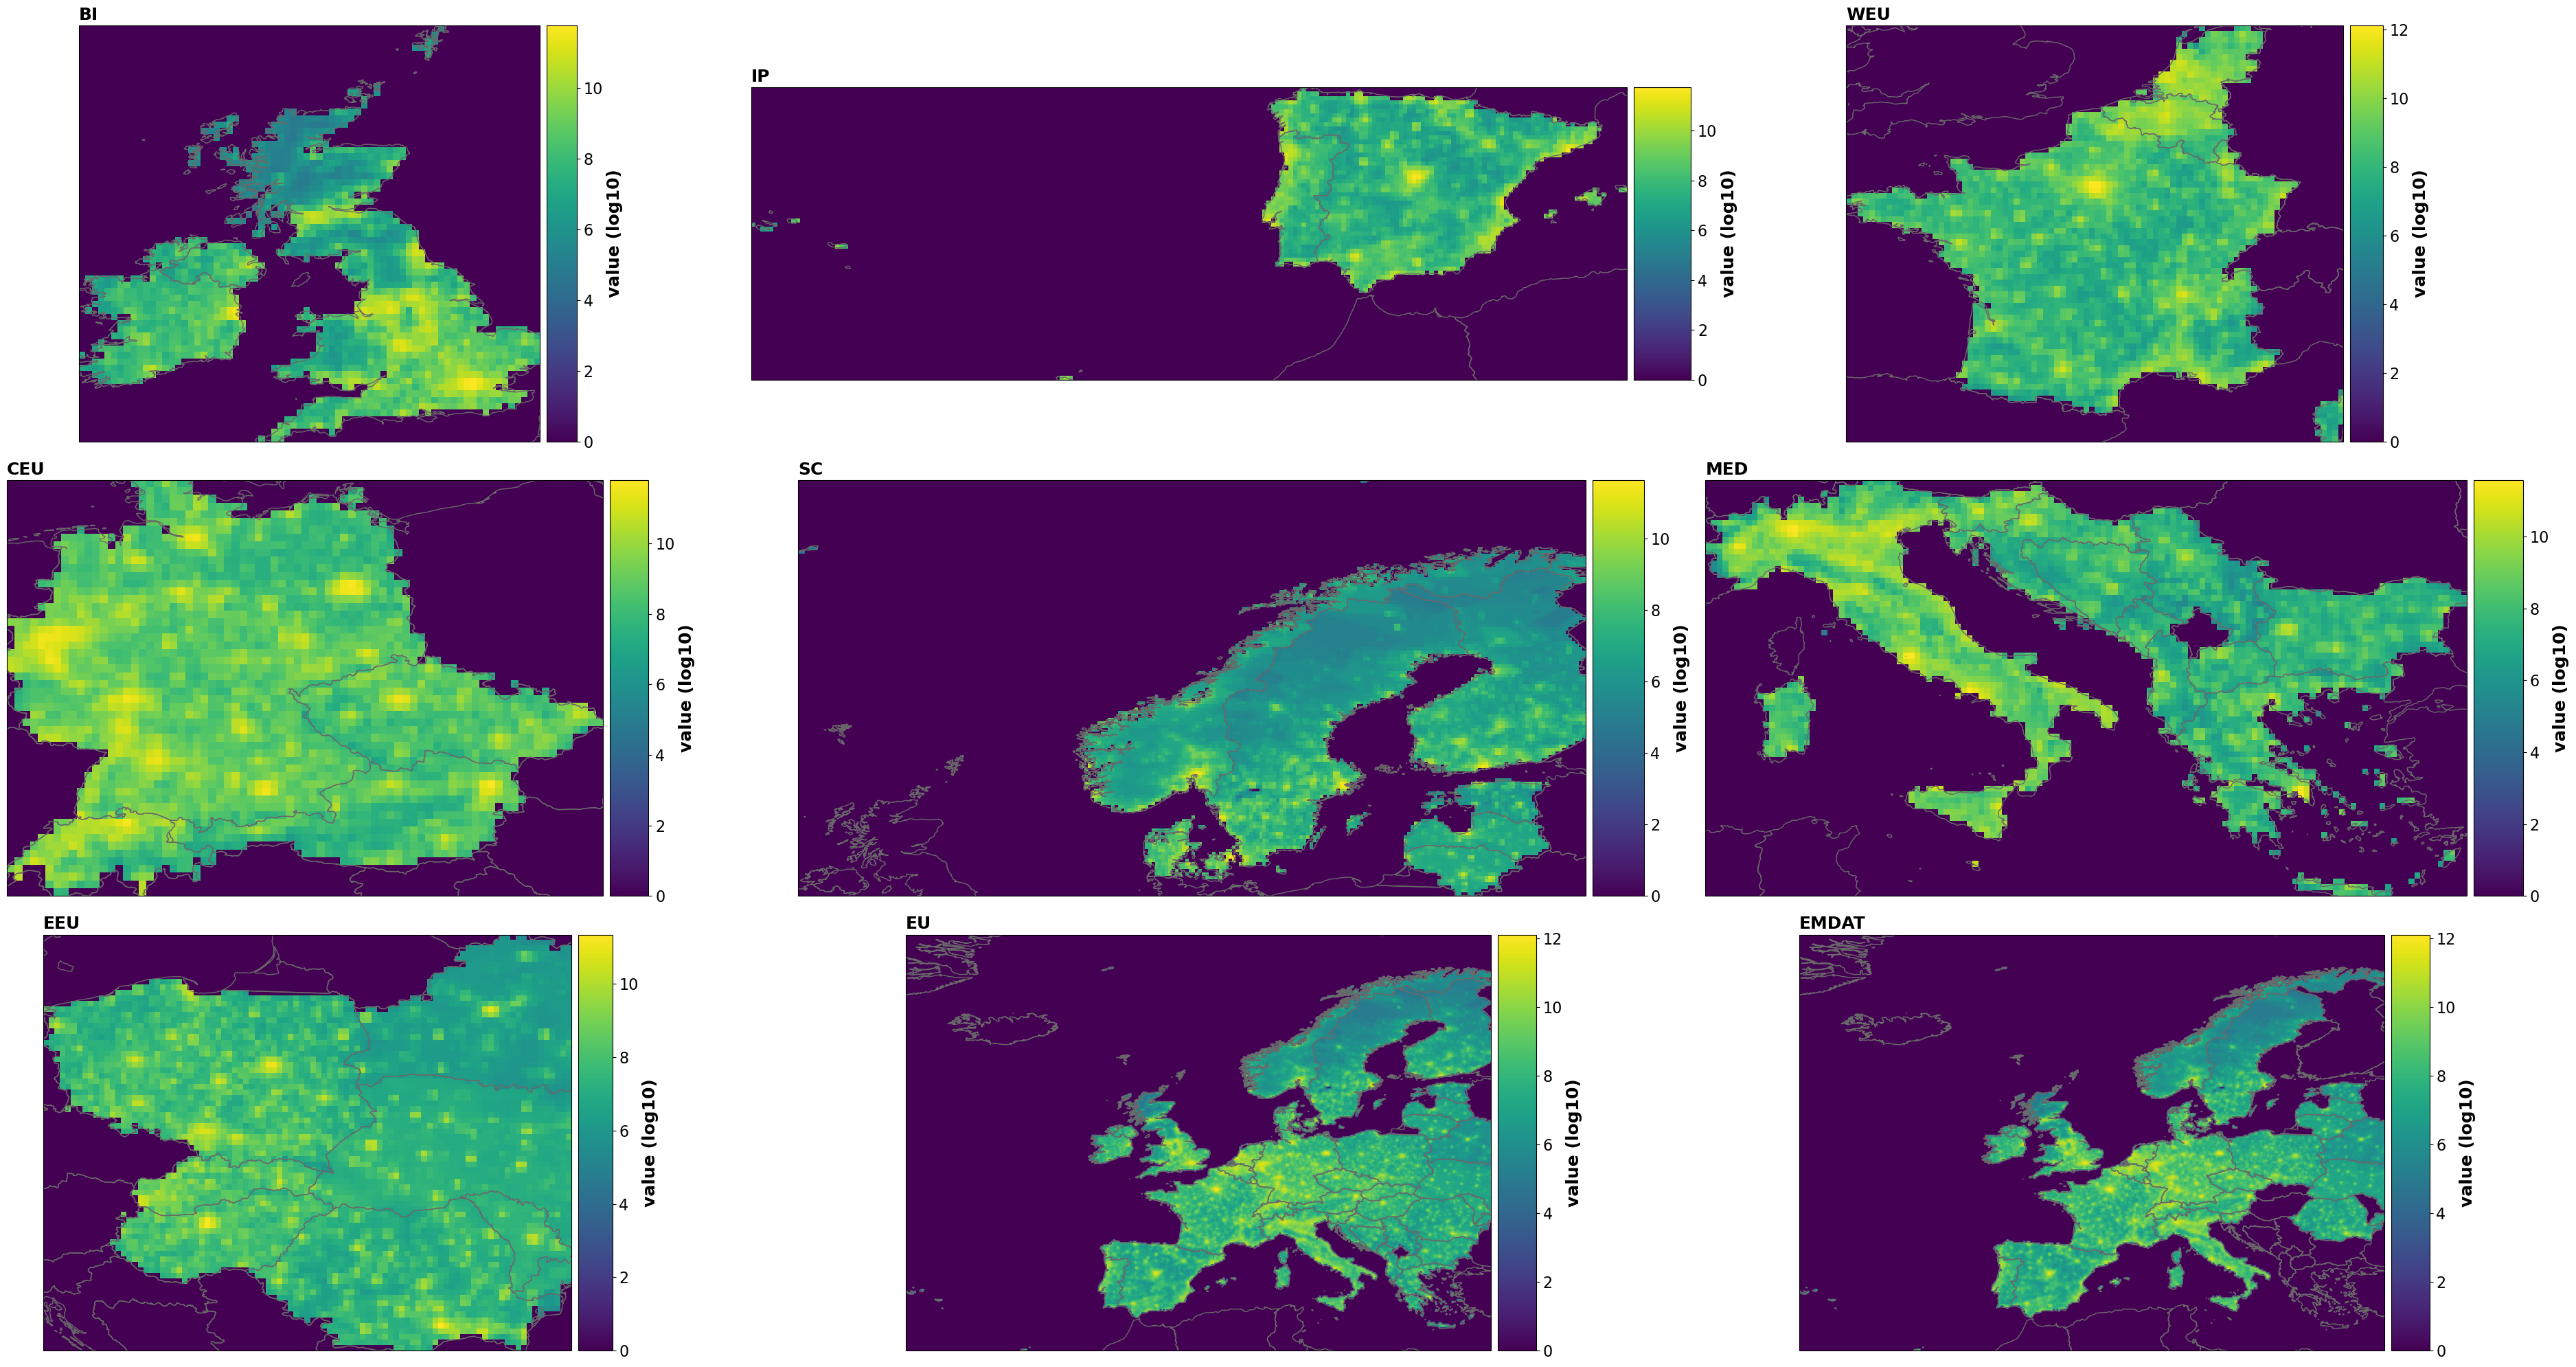

In [12]:
#plot regional exposures
fig, axs = plt.subplots(figsize=(40,20),nrows=int(len(reg_ctrids_dict.keys())/3),ncols=3,subplot_kw={'projection': ccrs.PlateCarree()})
iax = 0

for reg,reg_ids in reg_ctrids_dict.items():
    exp_sel = sel_reg_exp(reg_ids,exp)
    ax = axs.flatten()[iax]
    exp_sel.plot_raster(axis=ax)
    ax.set_title(reg,loc='left',fontweight='bold')
    iax+=1

## Load and prepare impact functions

In [13]:
# Get impact function from Schwierz 2010
from climada.entity.impact_funcs import storm_europe

#Get  Schwierz Impf
impFunc_schw = storm_europe.ImpfStormEurope.from_schwierz()

impFunc_schw.id = 1
impFunc_schw.haz_type = 'WS'
impFunc_schw.name = 'Sw2010'
impFunc_schw.check()

In [14]:
# Implement impact function cubic excess over threshold from Klawa 2003
from climada.entity import ImpactFunc
imp_fun_cub = ImpactFunc()
imp_fun_cub.haz_type = 'WS'
imp_fun_cub.name = 'CubEOT'
# provide unit of the hazard intensity
imp_fun_cub.intensity_unit = 'm/s'
imp_fun_cub.intensity = np.linspace(0, 1, num=20)
imp_fun_cub.mdd = imp_fun_cub.intensity**3
imp_fun_cub.intensity = np.append(imp_fun_cub.intensity, [100])
imp_fun_cub.mdd = np.append(imp_fun_cub.mdd, [1])
imp_fun_cub.paa = np.ones(imp_fun_cub.intensity.shape)

# check if the all the attributes are set correctly
imp_fun_cub.id = 2
imp_fun_cub.check()


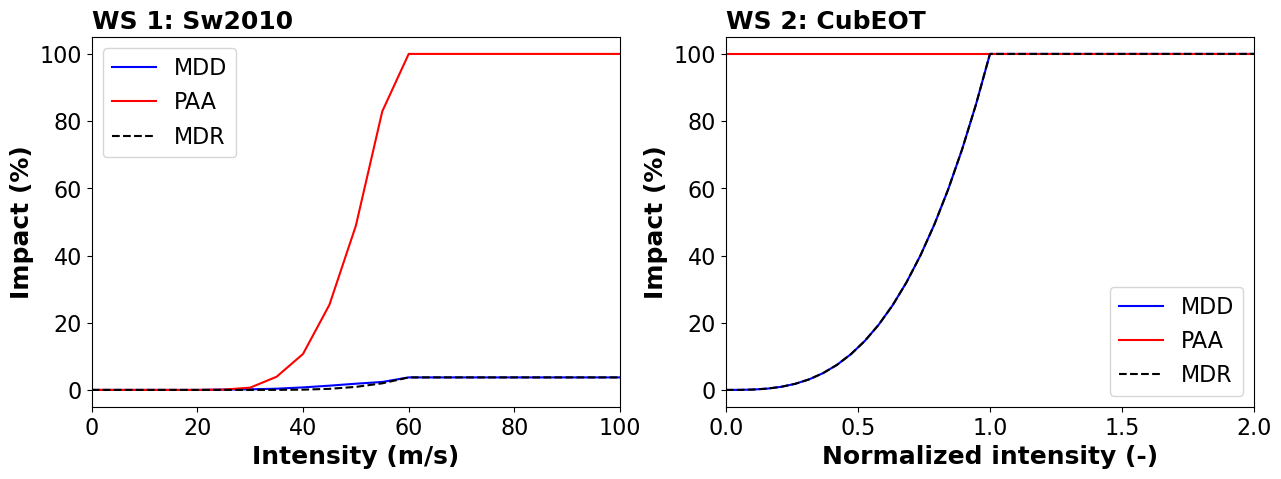

In [15]:
# generate 1 impact function set for all functions, and a dict containing the function name and its id in the set
from climada.entity import ImpactFuncSet
impf_list = [impFunc_schw,imp_fun_cub]
impf_namelist = []
impf_dict = {}
impf_set = ImpactFuncSet()

for impf in impf_list:
    impfname = impf.name
    impf_namelist.append(impfname)
    impf_dict[impfname] = impf.id
    impf_set.append(impf)
    impf_set.check()

axs = impf_set.plot()
fig = axs[0].get_figure()
fig.set_figwidth(15)
axs[1].set_xlabel('Normalized intensity (-)')
axs[1].set_xlim((0,2));

## ERA5 damage calculation

In [23]:
## subselect exposure according to the countries in EMDAT
regids_emdat = reg_ctrids_dict['EMDAT']
exp_emdat = sel_reg_exp(regids_emdat,exp)

In [24]:
#select climate models, used scenarios (historical, ssp585,...), impact functions and calibration type
#constants
bnera5 = 'era5_WG10_br_day_EU_winE' #filename of ERA5 WG10 data
pastname = 'historical'
timeres = 'time' #name of the time dimension of netcdf
eravar = 'WG10' #name of the variable of netcdf

#impact functions
impf_dict = impf_dict # dictionary mapping impact functions names to their ids
impf_set = impf_set # impact function set
pp_func_dic = pp_func_dic # dict with the preprocessing functions for the impact functions

#preprocessing
gst_fact = 1 #gust factor
qt = 0.98 # quantile threshold for event detection
cut = 1.5E5 # area threshold for event detection
mask_abs = 15 # absolute threshold for damage calculation
regrid = True # regrid ERA5 to rg_res
rg_res = 1 # horizontal regridding in degree

#climada constants
haz_type = 'WS'
haz_id = 1
dist_th_cst = 300 #const treshold in km for assign centroids

#prepare savename
processings = ["qt"+str(qt)[-2:]+"pst","mask_abs"+format(mask_abs,'.0f'),"cutarea"+format(cut,'.1E').replace("+0",'').replace('.','-'),"gst"+format(gst_fact,'.2f').replace(".",'-')]
era_bn_proc = make_fn(processings,bnera5)

In [25]:
#initiate df to save results
metrics = ['aai_agg',1,10,15,30] # impact metrics to be computed, select aai_agg for Average Annual Damage, and integers for rps

iterables = [metrics,impf_dict.keys()]
col_idx1 = pd.MultiIndex.from_product(iterables,names=["metric","Impf"])
res_df = pd.DataFrame(columns=metrics,index=impf_dict.keys())

In [26]:
##main calculation cell.
from climada.engine import Impact, ImpactCalc

#Use savehaz, saveimpcsv, saveimpmat to save hazards or/and imapcts.
savehaz = False
saveimpmat = True
saveimpcsv = True
savestats = True

#get era5
era_ds = xr.open_dataset(data_folder+bnera5+'.nc')
era_ds = era_ds.rename_vars({eravar:pastname})

#get horizontal resolutions from era5
latres, lonres = get_lat_lon_res(era_ds)
latin = era_ds.lat
lonin = era_ds.lon

#gust factor
gust_era = gst_fact*era_ds

if regrid: #regrid era5
    latout = np.arange(min_lat,max_lat+rg_res,rg_res)
    lonout = np.arange(min_lon,max_lon+rg_res,rg_res)
    gust_era = gust_era.interp(lat=latout,lon=lonout, method='linear',kwargs={"fill_value": 'extrapolate'})

for impfname,if_id in impf_dict.items():

    # get processing func
    preprocess_func = pp_func_dic[impfname]
    pp_funcname = str(preprocess_func).split(" ")[1]

    # preprocess + detect storm days
    gust_pp = preprocess_func(gust_era,qt,mask_abs=mask_abs,cutarea=cut,timeres=timeres,pastname=pastname,futname=pastname,stack=False)

    #prepare hazards centroids
    haz = set_centroids(gust_pp,stack=False,timeres="time",plot=False)

    # deepcopy exposure before assigning centroids
    exp_sel = cp.deepcopy(exp_emdat)

    # Exposures: rename column and assign id
    exp_sel.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
    exp_sel.gdf['impf_' + haz_type] = if_id

    #assign centroids
    exp_sel.assign_centroids(haz,distance='euclidean',threshold=300)
    exp_sel.check()

    #compute impacts
    #past
    start_time = timer()
    impcalc = ImpactCalc(exp_sel, impf_set, haz)
    imp = impcalc.impact(save_mat=saveimpmat, assign_centroids=False)
    time_delta_past = timer() - start_time
    print(time_delta_past)

    #save results
    if savestats:
        for imet,met in enumerate(metrics):
            if met=='aai_agg':
                impmet = imp.aai_agg
            else:
                impmet = imp.calc_freq_curve(return_per=met).impact
            res_df.loc[impfname,met] = impmet


    ##save files
    # saving names

    savenamehaz = make_fn(['haz',pp_funcname],bnera5)
    savenameimp = make_fn(['imp',impfname,pp_funcname],era_bn_proc)

    #save hazards
    if savehaz:
        try:
            haz.write_hdf5(results_folder+'hazard/'+savenamehaz+'.h5')
        except OSError:
            mkdir(data_folder+'hazard/')
            haz.write_hdf5(results_folder+'hazard/'+savenamehaz+'.h5')
    #save impacts
    if saveimpcsv:
        try:
            imp.write_csv(results_folder+'impact/'+savenameimp+'.csv')
        except OSError:
            mkdir(results_folder+'impact/')
            imp.write_csv(results_folder+'impact/'+savenameimp+'.csv')
    if saveimpmat:
        try:
            imp.write_sparse_csr(results_folder+'impact/'+savenameimp+'.npz')
        except OSError:
            mkdir(data_folder+'impact/')
            imp.write_sparse_csr(results_folder+'impact/'+savenameimp+'.npz')

res_df = res_df.astype(np.float64)

0.15488383299998532
0.1855051249999633


In [27]:
res_df

,aai_agg,1,10,15,30
Sw2010,1.929322e+09,3.210859e+08,2.606342e+09,3.339136e+09,3.600549e+09
CubEOT,3.073582e+09,5.385877e+08,3.118846e+09,3.465101e+09,4.605306e+09


In [28]:
## Compute correction factor for CubEOT
aai_agg_emdat = 1000*3073582.5 # taken from EM-DAT: Guha-Sapir, D.: EM-DAT, CRED / UCLouvain, Brussels, Belgium, www.emdat.be, (last access: 13 November 2021), 2021.

CubEOT_corr_fact = aai_agg_emdat/res_df.loc["CubEOT","aai_agg"]
print(CubEOT_corr_fact)

1.0


In [29]:
#rescale CubEOT impact function
[impf] = impf_set.get_func(fun_id=2) #get CubEOT
impf_set.remove_func(fun_id=2) #remove CubEOT
impf.mdd *= CubEOT_corr_fact
impf_set.append(impf)

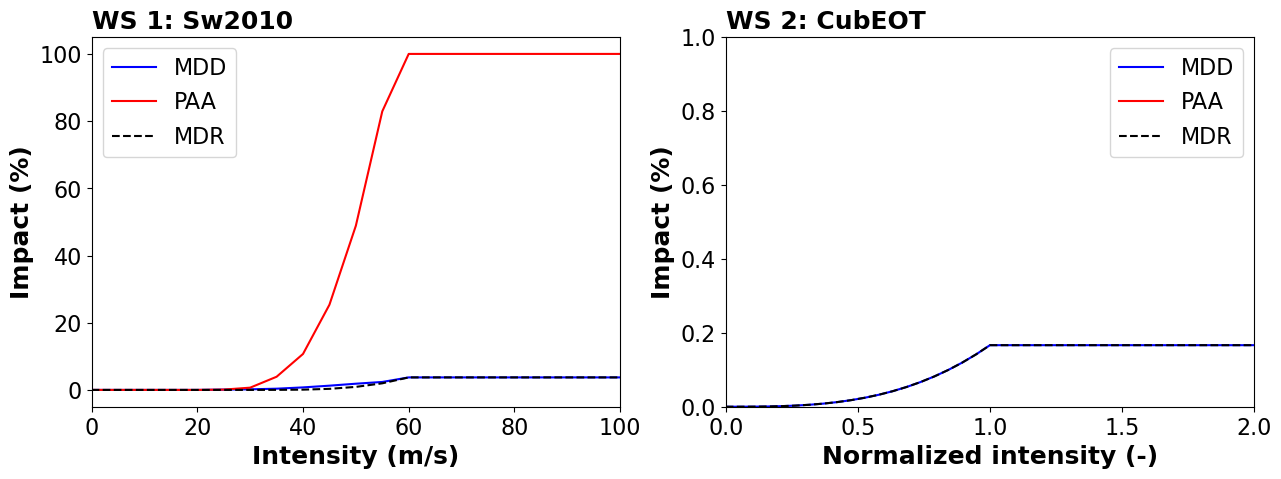

In [30]:
axs = impf_set.plot()
fig = axs[0].get_figure()
fig.set_figwidth(15)
axs[1].set_xlabel('Normalized intensity (-)')
axs[1].set_xlim((0,2));
axs[1].set_ylim((0,1));

## Comparison with EM-DAT damages
First, damages need to be calcutated, using the rescaled CubEOT impact function and saved by enabling saveimp=True.
Secondly, extratropical storm damage needs to be downloaded from the EM-Dat database

In [31]:
#read EMDAT data
fnemdat = 'emdat_EU_1960_2022_ETC.xlsx'
ETC_data = pd.read_excel(data_folder+fnemdat,header=6)

# keep only damage data
keep = ['Dis No','Event Name','Seq', 'Year','Country','Region','Dis Mag Value','Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month',
       'End Day', 'Reconstruction Costs (\'000 US$)',
       'Insured Damages (\'000 US$)', 'Total Damages (\'000 US$)','Total Damages, Adjusted (\'000 US$)']
ETC_small = ETC_data[keep]

#only keep data before 2010
ETC_small = ETC_small.where(ETC_small['Start Year']<=2010).dropna(how='all',axis=0)

#correct for divergeing storm names
ETC_small['Event Name'][(ETC_small['Event Name'] == 'Cilly, Désirée et Fanny')] = 'Cilly, Desiree, Fanny'
ETC_small['Event Name'][(ETC_small['Event Name'] == 'Jeannet')] = 'Jeanett'


In [32]:
#get days of actual storms
strm_idx = ETC_small['Event Name'].unique() #storm event names
storm_days_dict = dict() #store storm days
storm_damage_dict = dict() #store total damage over the domain per storm event
storm_days_list = []

for stormname, group in ETC_small.groupby('Event Name'):

    if len(group['Start Month'].unique()) > 1: #if the storm spans over two separate months, take the biggest day to start the time index
        dft_start = pd.DataFrame({"year": group['Start Year'].min(), "month": group['Start Month'].min(), "day": group['Start Day'].max()},index=['start'])
    else: #else take the smallest day to start the time index
        dft_start = pd.DataFrame({"year": group['Start Year'].min(), "month": group['Start Month'].min(), "day": group['Start Day'].min()},index=['start'])
    if len(group['End Month'].unique()) > 1: #if the storm spans over two separate months, take the smallest day to end the time index
        dft_end = pd.DataFrame({"year": group['End Year'].max(), "month": group['End Month'].max(), "day": group['End Day'].min()},index=['end'])
    else: #else take the biggest day to end the time index
        dft_end = pd.DataFrame({"year": group['End Year'].max(), "month": group['End Month'].max(), "day": group['End Day'].max()},index=['end'])

    #create date range index
    dti_start = pd.to_datetime(dft_start,format='YYYY-MM-DD')[0]
    dti_end= pd.to_datetime(dft_end,format='YYYY-MM-DD')[0]
    storm_time_idx = pd.date_range(start=dti_start,end=dti_end)

    #write to dict
    storm_days_dict[stormname] = storm_time_idx
    storm_damage_dict[stormname] = 1000*group["Total Damages, Adjusted ('000 US$)"].sum()
    storm_days_list.append(storm_time_idx)

#create long date range index including all storm days
#storm_days_idx_long = storm_days_list[0].union_many(storm_days_list[1:]) union_many is deprecated
storm_days_idx_long = storm_days_list[0]
for dti in storm_days_list[1:]:
    storm_days_idx_long = storm_days_idx_long.union(dti)


In [33]:
#Compute statistics with respect to EM-DAT events
impflist = ['CubEOT','Sw2010']

#preprocessing
gst_fact = 1
qt = 0.98
cuts=[1.5E5]
mask_abs = 15

#preproc field
processings = ["qt"+str(qt)[-2:]+"pst","mask_abs"+format(mask_abs,'.0f'),"cutarea"+format(cuts[0],'.1E').replace("+0",'').replace('.','-'),"gst"+format(gst_fact,'.2f').replace(".",'-')]
era_bn_proc = make_fn(processings,bnera5)

df_dict = {}
for impfname in impflist:

    ##filenames
    pp_funcname = str(pp_func_dic[impfname]).split(" ")[1]
    savenameimp = make_fn(['imp',impfname,pp_funcname],era_bn_proc)
    impcsvfn = results_folder+'impact/'+savenameimp+'.csv'
    impmatfn = results_folder+'impact/'+savenameimp+'.npz'

    ## open impacts
    #past
    imp = Impact()
    imp = imp.from_csv(impcsvfn)
    imp.imp_mat = imp.read_sparse_csr(impmatfn)
    imp_mat = imp.local_exceedance_imp(return_periods=[met])
    imp_mat = imp_mat.reshape((imp_mat.shape[1],))

    #select emdat days
    # convert to same time format, find storm days that were missed and drop them
    imp.event_name = pd.to_datetime(imp.event_name).strftime('%Y-%m-%d %H:%M')
    imp_emdat = imp.select(event_names=storm_days_idx_long.strftime('%Y-%m-%d %H:%M'))
    missed = storm_days_idx_long.strftime('%Y-%m-%d %H:%M').difference(imp.event_name) #difference between model storm days and actual storm days
    new_id = storm_days_idx_long.drop(missed)

    #initiate df
    modelled_day_impacts = pd.DataFrame({"impacts":imp_emdat.at_event.copy()},index=new_id) #storm damage modelled
    observed_vs_modelled_df = pd.DataFrame(columns=['modelled','observed'],index=storm_days_dict.keys())

    #resample to have one day by event
    for stormname, storm_days in storm_days_dict.items():
        storm_days = storm_days.strftime('%Y-%m-%d %H:%M')
        #if a storm day is missed
        for miss_day in missed.tolist():
            if miss_day in storm_days.tolist():
                miss = True
            else:
                miss = False
        if miss:
            storm_days = storm_days.drop(missed)
        #modelled_imp_dict[stormname] = modelled_day_impacts.loc[storm_days].sum()
        observed_vs_modelled_df.loc[stormname,'modelled'] = format(modelled_day_impacts.loc[storm_days].sum().values[0],'.2E')
        observed_vs_modelled_df.loc[stormname,'observed'] = format(storm_damage_dict[stormname],'.2E')
    df_dict[impfname] = observed_vs_modelled_df

obs_vs_mod_df = pd.concat(df_dict,axis=1)
obs_vs_mod_df = obs_vs_mod_df.astype(np.float64)

In [34]:
obs_vs_mod_df

CubEOT                      Sw2010              
                           modelled      observed      modelled      observed
Anatol                 6.560000e+08  4.760000e+09  5.960000e+08  4.760000e+09
Calvann                2.820000e+08  4.490000e+08  1.340000e+08  4.490000e+08
Cilly, Desiree, Fanny  3.610000e+08  1.080000e+09  4.030000e+08  1.080000e+09
Emma                   1.600000e+09  2.270000e+09  5.840000e+08  2.270000e+09
Erwin                  1.090000e+09  7.820000e+09  2.070000e+09  7.820000e+09
Jeanett                1.660000e+09  3.810000e+09  1.020000e+09  3.810000e+09
Klaus                  1.000000e+09  6.440000e+09  6.550000e+08  6.440000e+09
Kyrill                 5.590000e+09  1.180000e+10  3.630000e+09  1.180000e+10
Lothar                 6.260000e+09  1.850000e+10  4.240000e+09  1.850000e+10
Martin                 1.760000e+09  6.670000e+09  8.410000e+08  6.670000e+09
Xynthia                6.940000e+08  7.550000e+09  4.170000e+08  7.550000e+09

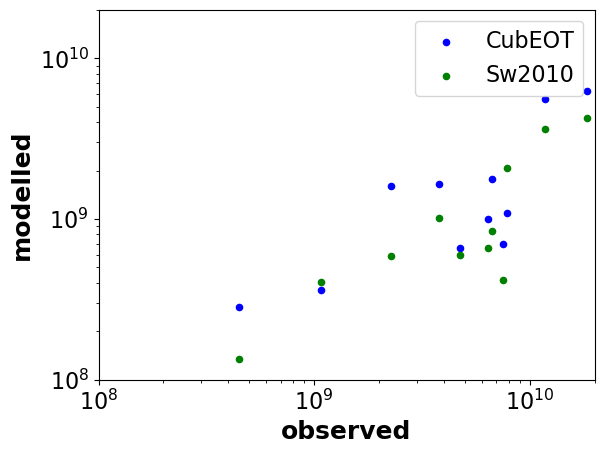

In [35]:
ax = obs_vs_mod_df['CubEOT'].plot.scatter(x='observed', y='modelled',label='CubEOT',color='blue')
obs_vs_mod_df['Sw2010'].plot.scatter(ax=ax,x='observed', y='modelled',label='Sw2010',color='green')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1E8,2E10]);
ax.set_ylim([1E8,2E10]);

In [36]:
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_percentage_error
impf = 'Sw2010'
y_true = obs_vs_mod_df[impf]['observed']
y_pred = obs_vs_mod_df[impf]['modelled']
met = mean_absolute_percentage_error(y_true,y_pred)
print(100*met)

78.12424109673802


## Damage calculation
Use stack=True to stack model members on top of each other, set stack=False to consider each member separately.
Use savehaz, saveimpcsv, saveimpmat to save hazards or/and impacts.
1) Loop over impact functions
2) Loop over scenarios
3) Loop over climate models
4) Loop over model members


In [47]:
#select climate models, used scenarios (historical, ssp585,...), impact functions and calibration type
#climate models
#modlist_allscen represents GCMs for which at least 3 members for scenarios ssp126, ssp245, ssp357, and ssp585 are available
#modlist_ssp585 contains the GCM names for which only at least one member of the ssp585 is available

modlist_allscen = ['CanESM5','CNRM-CM6-1','CNRM-ESM2-1','EC-Earth3-Veg','EC-Earth3-Veg-LR','IPSL-CM6A-LR','MIROC-ES2L',
           'UKESM1-0-LL','MRI-ESM2-0','FGOALS-g3','ACCESS-ESM1-5','MIROC6','MPI-ESM1-2-LR','KACE-1-0-G']
modlist_ssp585 = ['AWI-CM-1-1-MR','BCC-CSM2-MR','CNRM-CM6-1-HR','EC-Earth3','EC-Earth3-CC','HadGEM3-GC31-LL',
                  'GISS-E2-1-G','GFDL-CM4','CMCC-CM2-SR5','CMCC-ESM2','HadGEM3-GC31-MM','NESM3','MPI-ESM1-2-HR','INM-CM4-8','INM-CM5-0','ACCESS-CM2']
modlist = modlist_allscen[:4] #modlist used for calculations
#scenarios
scen_used= ['historical','ssp126','ssp245','ssp370','ssp585']
#scen_used= ['historical','ssp585']
pastname = 'historical'

timeres = 'day' #time dimension of the netcdf

#members
nmems = 3
stack = False #stack members or consider them separately

#impact functions
impf_dict = impf_dict # dictionary mapping impact functions names to their ids
impf_set = impf_set # impact function set
pp_func_dic = pp_func_dic # dict with the preprocessing functions for the impact functions

#regions
#reglist = ['EU', 'BI', 'IP', 'WEU', 'CEU', 'MED', 'SC', 'EEU']
reglist = ['EU']
#preprocessing
gst_fact = 1.00
qt = 0.98
cut=1.5E5
mask_abs = 15 #mask everything below 15 m/s

#naming
bnSWM = 'bias_corrWG10_SWM_br_day_EU_winE' #base name of sfcWindmax files
processings = ["qt"+str(qt)[-2:]+"pst","mask_abs"+format(mask_abs,'.0f'),"cutarea"+format(cut,'.1E').replace("+0",'').replace('.','-'),"gst"+format(gst_fact,'.2f').replace(".",'-')]
bnSWM_proc = make_fn(processings,bnSWM) #basename including preprocessing to save data

#climada constants
haz_type = 'WS'
haz_id = 1
dist_th = 300 #const treshold in km for assign centroids

#saving
savehaz = True #save hazard file, needed for later uncertainty and sensitivity quantification
saveimpcsv = False #save impact csv, needed to compute boxplots, impact maps and EFCs
saveimpmat = False #save impact matrix, needed to compute impact maps
savestats = False #save write stats in a pandas dataframe
metrics = ['aai_agg',1,10,15,30] # impact metrics to be computed, select aai_agg for Average Annual Damage, and integers for rps

In [48]:
#initiate df to save results
if stack:
    iterrows = [reglist,impf_dict.keys(),scen_used,modlist]
    row_idx= pd.MultiIndex.from_product(iterrows,names=["reg","impf","scen_used","model"])
    res_df = pd.DataFrame(columns=metrics,index=row_idx)
    iterrowst = [reglist,impf_dict.keys(),scen_used,modlist]
    row_idxt= pd.MultiIndex.from_product(iterrowst,names=["reg","impf","scenario","model"])
else:
    iterrows = [reglist,impf_dict.keys(),scen_used,modlist,range(nmems)]
    row_idx= pd.MultiIndex.from_product(iterrows,names=["reg","impf","scen_used","model","member"])
    res_df = pd.DataFrame(columns=metrics,index=row_idx)
    iterrowst = [reglist,impf_dict.keys(),scen_used,modlist,range(nmems)]
    row_idxt= pd.MultiIndex.from_product(iterrowst,names=["reg","impf","scenario","model","member"])

res_df = res_df.sort_index()

In [49]:
##main calculation cell.

for modid, modname in enumerate(modlist):
    start_time = timer()

    #filename of particular model
    fnSWM = bnSWM[:14]+modname+bnSWM[13:]+".nc"

#make_fn([modname],bnSWM,filetype=".nc")

    #open netcdf
    ncdf = xr.open_dataset(data_folder+fnSWM)
    latres, lonres = get_lat_lon_res(ncdf)
    latout = ncdf.lat
    lonout = ncdf.lon


    #select number of members to be considered
    if stack:
        nmems=1
    else:
        nmems = len(ncdf.member)

    for scen in scen_used:
        ncdfw = ncdf[[pastname,scen]]

        #apply gust factor
        gust_ds = gst_fact*ncdfw
        #iterate over the members
        for imem in range(nmems):

            #combine members or take them separately
            if stack:
                mem_da = gust_ds
            else:
                mem_da = gust_ds.sel(member=imem)

            for impfname,if_id in impf_dict.items():

                #get processing func
                preprocess_func = pp_func_dic[impfname]
                pp_funcname = str(preprocess_func).split(" ")[1]

                #preprocess fields
                gust_pp = preprocess_func(mem_da,qt,mask_abs=mask_abs,cutarea=cut,timeres=timeres,pastname=pastname,futname=scen,stack=stack)

                if scen != 'historical':
                    gust_pp_sel = gust_pp[scen]
                else:
                    gust_pp_sel = gust_pp

                #prepare hazards centroids
                haz = set_centroids(gust_pp_sel,stack=stack,timeres=timeres,plot=False)

                #write haz tag
                #haz.tag.description = "Latres: "+format(latres,'.2f')+"\nLonres: "+format(latres,'.2f')

                #base names to save files
                if stack:
                    savenamehaz = make_fn(['haz','stacked',pp_funcname,scen,modname],bnSWM_proc,filetype='.h5')
                else:
                    savenamehaz = make_fn(['haz','nmem'+str(imem),pp_funcname,scen,modname],bnSWM_proc,filetype='.h5')

                #save hazards
                if savehaz:
                    try:
                        haz.write_hdf5(results_folder+'hazard/'+savenamehaz)
                    except OSError:
                        mkdir(results_folder+'hazard/')
                        haz.write_hdf5(results_folder+'hazard/'+savenamehaz)

                #loop of regions considered
                for reg in reglist:
                    start_time = timer()
                    #sel exposure according to region
                    reg_ids = reg_ctrids_dict[reg]
                    exp_sel = sel_reg_exp(reg_ids,exp)

                    # Exposures: rename column and assign id
                    exp_sel.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
                    exp_sel.gdf['impf_' + haz_type] = if_id

                    #assign centroids
                    exp_sel.assign_centroids(haz,distance='euclidean',threshold=dist_th)
                    exp_sel.check()

                    #compute impacts
                    impcalc = ImpactCalc(exp_sel, impf_set, haz)
                    imp = impcalc.impact(save_mat=saveimpmat, assign_centroids=False)

                    #save results
                    if savestats:
                        for met in metrics:
                            if met == 'aai_agg':
                                impmet = imp.aai_agg
                            else:
                                imp.calc_freq_curve(return_per=met).impact
                            if stack:
                                res_df.loc[(reg,impfname,scen,modname),met] = imp.aai_agg
                            else:
                                res_df.loc[(reg,impfname,scen,modname,imem),met] = imp.aai_agg

                    #save impacts
                    #base names to save files
                    if stack:
                        savenameimp = make_fn(['imp',reg,'stacked',impfname , pp_funcname,scen,modname],bnSWM_proc)
                    else:
                        savenameimp = make_fn(['imp',reg,'nmem'+str(imem),impfname , pp_funcname,scen,modname],bnSWM_proc)

                    if saveimpcsv:
                        try:
                            imp.write_csv(results_folder+'impact/'+savenameimp+'.csv')
                        except OSError:
                            mkdir(results_folder+'impact/')
                            imp.write_csv(results_folder+'impact/'+savenameimp+'.csv')
                    if saveimpmat:
                        try:
                            imp.write_sparse_csr(results_folder+'impact/'+savenameimp+'.npz')
                        except OSError:
                            mkdir(results_folder+'impact/')
                            imp.write_sparse_csr(results_folder+'impact/'+savenameimp+'.npz')
            time_delta_past = timer() - start_time
           #print("Computed impacts for "+modname+", "+", ".join(scen_used)+", "+", ".join(reglist)+", "+", ".join(impf_dict.keys())+": "+str(time_delta_past))
    ncdf.close()

res_df = res_df.astype(np.float64)

## Boxplots of regional damages

In [50]:
## First, import impact data
#select simulation
modlist = modlist_allscen+modlist_ssp585
modset = 'ssp585'
regions4 = ['BI','IP','WEU','CEU','MED','SC','EEU']

reglist = ['EU']+regions4
periods = ['historical','ssp585']
impf_namelist = ['CubEOT','Sw2010']
stack = True

bnSWM_proc = 'qt98pst_mask_abs15_cutarea1-5E5_gst1-00_bias_corrWG10_SWM_br_day_EU_winE'

#initiate df to save results
metrics = ['aai_agg',1,10,15,30] # impact metrics to be computed, select aai_agg for Average Annual Damage, and integers for rps

metddict = {}
for metric in metrics:
    if metric!= 'aai_agg':
        metddict[metric] = 'rp'+str(metric)
    elif metric == 'aai_agg':
        metddict[metric] = 'AAD'
iterables = [metddict.values(),periods,impf_namelist]
col_idx1 = pd.MultiIndex.from_product(iterables,names=["metric","period","Impf"])
res_df = pd.DataFrame(columns=col_idx1,index=modlist)

# import impact data
dict_res = {}
res_list = []
for reg in reglist:
    #initiate dfs
    res_df = pd.DataFrame(columns=col_idx1,index=modlist)

    for modid, modname in enumerate(modlist):
        for period in periods:
            for impfname in impf_namelist:
                # get processing func
                preprocess_func = pp_func_dic[impfname]
                pp_funcname = str(preprocess_func).split(" ")[1]

                if stack:
                    savenameimp = make_fn(['imp',reg,'stacked',impfname , pp_funcname,period,modname],bnSWM_proc)
                else:
                    savenameimp = make_fn(['imp',reg,'nmem'+str(imem),impfname , pp_funcname,period,modname],bnSWM_proc)

                #import impacts
                imp = Impact()
                imp = imp.from_csv(results_folder+'impact/'+savenameimp+'.csv')

                for metric, metname in metddict.items():
                    if metric == 'aai_agg':
                        stat = imp.aai_agg
                    else:
                        stat = imp.calc_freq_curve(return_per=metric).impact
                    res_df.loc[modname,(metname,period,impfname)] = stat

    res_df = res_df.astype(np.float64)
    #reg_df = reg_df.astype(np.float64)

    dict_res[reg] = [res_df]
    res_list.append(res_df)
reg_df = pd.concat(res_list,keys=reglist,names=['region'],axis=1)

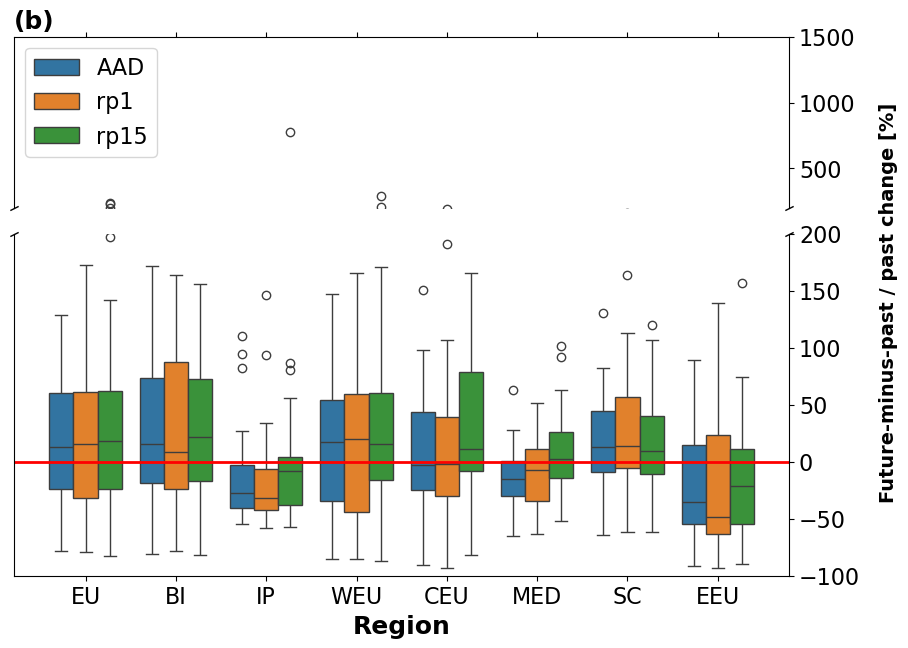

In [51]:
##Compute future-minus-historical / historical changes
idx = pd.IndexSlice
met_set = ['AAD','rp1', 'rp15'] # select metrics to plots
nmets = len(met_set)
impf_namelist = impf_namelist
sel_reg = reglist
modlist = modlist_allscen+modlist_ssp585
subset_df = reg_df.loc[modlist,idx[sel_reg,met_set,:,impf_namelist]]
diff_df = subset_df.loc[:,idx[:,:,"ssp585"]]-subset_df.loc[:,idx[:,:,"historical"]].values
diff_rel_df = 100*diff_df.div(subset_df.loc[:,idx[:,:,"historical"]].values)

#subset impf
impfi = "Sw2010"
diff_df_ss = diff_rel_df.loc[:,idx[:,:,:,impfi]].copy()
diff_df_ss.columns = diff_df_ss.columns.droplevel((2,3))
diff_df_ss.index.name = "model"
diff_df_ss.columns.name = "reg"
stacked_all = pd.DataFrame(diff_df_ss.stack(level=["region"])).reset_index()
stacked_all_met = pd.DataFrame(diff_df_ss.stack(level=["region","metric"]),columns=['value']).reset_index()
stacked_all_met.sort_values(by='value');

## Plot
import seaborn as sns
#plotting params
saving = False
break_ax = True #separate y-axis in two to deal with outliers
savenameimp = make_fn(['imp','stacked',impfname , pp_funcname,scen,modname],bnSWM_proc)
#title =' a) Multi-model distributions of changes in '+ ", ".join(met_set)+ ', aggregated by regions '
title = '(b)'

#labels option
ttsize = 16
sublabsize = 16
gllabsize = 8
cbarlabsize = 14
cbarticksize = 14

#colors
cpal = sns.color_palette("tab10")
#initiate fig
fig = plt.figure(figsize=(10,1*7))

nrows = 2

gridspec={'height_ratios':np.repeat([1/3,2/3],nrows/2)}
axs = fig.subplots(nrows=nrows,ncols=1,sharey=False,sharex=True,gridspec_kw=gridspec)
fig.subplots_adjust(hspace=0.1)  # adjust space between axes

ax1 = axs[0]
ax2 = axs[1]
sns.boxplot(ax=ax1,x="region",order=sel_reg, y="value",data=stacked_all_met,hue="metric",hue_order=met_set,palette=cpal)#palette="colorblind"
sns.boxplot(ax=ax2,x="region",order=sel_reg, y="value",data=stacked_all_met,hue="metric",hue_order=met_set,palette=cpal)#palette="colorblind"

#bottom axis
ax2.axhline(0,linewidth=2,color="r")
ax2.set_ylabel('')#,fontweight='bold'
ax2.set_xlabel('Region')#fontsize = cbarticksize,fontweight='bold'
ax2.yaxis.set_label_position("right")
ax2.get_legend().remove()
ax2.yaxis.tick_right()
ax2.tick_params(axis='y')# labelsize=cbarticksize
ax2.tick_params(axis='x')#labelsize=cbarticksize

#top axis
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_title(title,loc='left')#fontsize = cbarticksize,fontweight='bold'
ax1.tick_params(axis='y')#labelsize=cbarticksize
ax1.tick_params(axis='x')#labelsize=cbarticksize
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.legend(loc="upper left")

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(200, 1500)  # outliers only
#ax1.set_yscale('log')
ax2.set_ylim(-100, 200)  # most of the data

#common y label
fig.supylabel('Future-minus-past / past change [%]',x=0.99,fontsize = cbarticksize,fontweight='bold')
fig.supylabel

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

#add breaks
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)],
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)#markersize=12
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


## Damage maps

In [52]:
#select simulation
modlist = modlist_allscen+modlist_ssp585

modset = 'allmods'
pastname = 'historical'
futname = 'ssp585'
scenlist = [pastname,futname]
impfname = 'Sw2010'
pp_funcname = str(pp_func_dic[impfname]).split(" ")[1]
bnSWM_proc = 'qt98pst_mask_abs15_cutarea1-5E5_gst1-00_bias_corrWG10_SWM_br_day_EU_winE'
met_list = ['aai'] #metrics to select
met_dict = dict()
data_dict = dict()

for met in met_list:
    met_dict[met] = dict()

for scen in scenlist:
    data_dict[scen] = cp.deepcopy(met_dict)

savenameimp = make_fn(['imp','stacked',impfname , pp_funcname,scen,modname],bnSWM_proc)
colnames1 = ['AAI past','AAI future', 'AAI future-past']
aai_df = pd.DataFrame(columns=colnames1,index=modlist)
colnames2 = ['15yr impact past','15yr impact future', '15yr impact future-past']
rp_df = pd.DataFrame(columns=colnames2,index=modlist)


In [53]:
## Load damage data and compute spatial distribution of the damage metrics for each GCM
## Spatial maps are stored in a dict structure
for modname in modlist:
    for scen in scenlist:

        # get processing func
        pp_funcname = str(pp_func_dic[impfname]).split(" ")[1]

        if stack:
            savenameimp = make_fn(['imp','EU','stacked',impfname , pp_funcname,scen,modname],bnSWM_proc)
        else:
            savenameimp = make_fn(['imp','EU','nmem'+str(imem),impfname , pp_funcname,scen,modname],bnSWM_proc)

        ## open impacts
        #past
        imp = Impact()
        imp = imp.from_csv(results_folder+'impact/'+savenameimp+'.csv')
        imp.imp_mat = imp.read_sparse_csr(results_folder+'impact/'+savenameimp+'.npz')

        for met in met_list:
            start_time = timer()
            if met == 'aai':
                imp_met = imp.eai_exp
            else:
                imp_met = imp.local_exceedance_imp(return_periods=[met])
                imp_met = imp_met.reshape((imp_met.shape[1],))

            time_delta_past = timer() - start_time
            #print(time_delta_past)
            data_dict[scen][met][modname] = imp_met

            del imp_met
        del imp

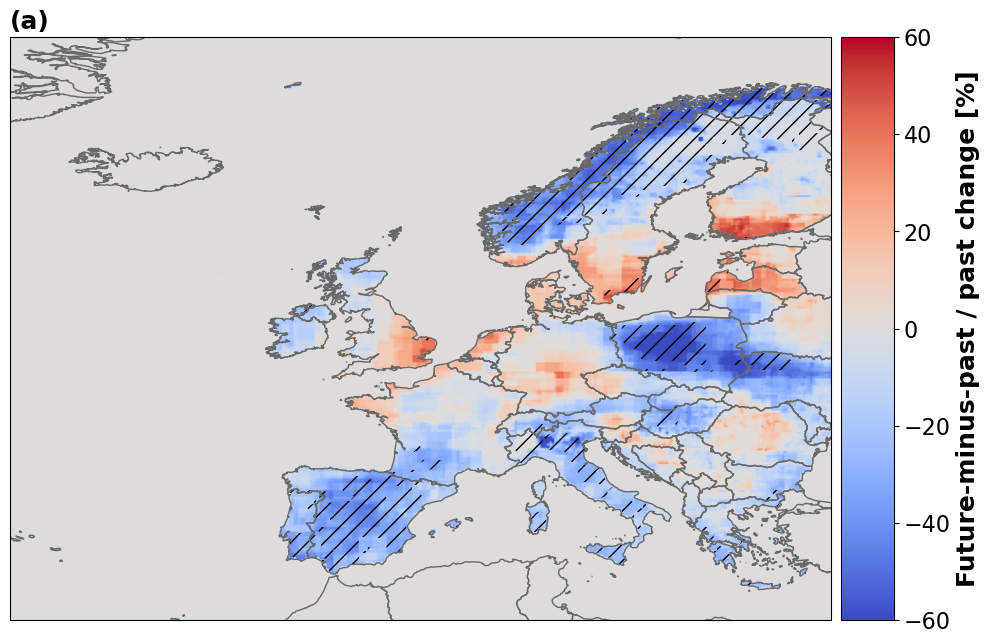

In [54]:
##Plot multimodel mean (or median) change in AAI and rp event
import matplotlib as mpl

#select data
modlist = modlist_allscen+modlist_ssp585
modset = 'allmods'
nmods = len(modlist)
pastname = 'historical'
futname = 'ssp585'

#select metrics
sel_mets = ['aai']
nmets = len(sel_mets)
const = 1 #add a constant value to historical damages to avoid dividing by 0

#function to compute fut-hist / hist changes
def calc_rel_diff(metp, metf, const=0):
    metd = 100*((metf-metp)/(metp+const)) #version 1: add a constant
    metd[np.isinf(metd)] = np.nan #change inf to 0s
    return metd

#plotting param
saving = False
stat = 0.5
nrows = nmets
ncols = 1
colorLabel = 'Future-minus-past / past change [%]'
maintitle = "(a)"
plot_agr = True #plot model agreement
agr_lvl = 0.75

#colormap
cmap = mpl.colormaps['coolwarm']
cmap.set_bad('None')

#hatching
hatchsign = ['//']
sign_lvls = [agr_lvl,1]


#initiate plot
fig = plt.figure(figsize=(10*ncols,7*nrows))
axs = fig.subplots(nrows=nmets, ncols=1,subplot_kw={'projection': ccrs.PlateCarree()},sharey=True)

#preload any impact object
savenameimp = make_fn(['imp', 'EU','stacked',impfname , pp_funcname,scenlist[0],modlist[0]],bnSWM_proc)
imp = Impact()
imp= imp.from_csv(results_folder+'impact/'+savenameimp+'.csv')
imp.imp_mat = imp.read_sparse_csr(results_folder+'impact/'+savenameimp+'.npz')

#load exposure file and create dataarray from exp to plot model agreement
exp_plot = Exposures.from_hdf5(results_folder+'exposure/exp_m1_n1_cropped1_res600.h5')
agr_df = cp.deepcopy(exp_plot.gdf[['value','latitude','longitude']])

for i,met in enumerate(sel_mets):

    met_list_ss = []
    pos_agr_list = []
    neg_agr_list = []
    for modname in modlist:

        #get damage metric map from dictionarry
        metp = data_dict[pastname][met][modname].copy()
        metf = data_dict[futname][met][modname].copy()

        #compute fut-minus-historical / historical change
        metd = calc_rel_diff(metp, metf, const=const)
        met_list_ss.append(metd)
        if plot_agr:
            pos_mod_agr = cp.deepcopy(metd)
            neg_mod_agr = cp.deepcopy(metd)

            pos_mod_agr[np.where(metd>0)] = 1
            neg_mod_agr[np.where(metd<=0)] = 1
            pos_mod_agr[np.where(metd<=0)] = 0
            neg_mod_agr[np.where(metd>0)] = 0

            neg_agr_list.append(neg_mod_agr)
            pos_agr_list.append(pos_mod_agr)

    #stack the impact maps
    met_ar_ss = np.vstack(met_list_ss)
    if plot_agr:
        pos_agr_ar = np.vstack(pos_agr_list)
        neg_agr_ar = np.vstack(neg_agr_list)

    #compute either mean or median or other statisitc
    if stat == 'mean':
        met_stat = met_ar_ss.mean(axis=0)
    else:
        met_stat = np.quantile(met_ar_ss,stat,axis=0) #use nanmean or nanquantile instead?
        if stat==0.5:
            statname = 'median'
        else:
            statname = format(100*stat,'3.1f')
        #stt = 'Multimodel '+statname+' change in '+str(met)+'yr return event\n'+impf_name

    #write impact map into impact object
    imp.eai_exp = met_stat

    #plot
    if nmets != 1:
        axi = axs[i]
    else:
        axi = axs
    imp.plot_raster_eai_exposure(axis=axi,raster_f=lambda x:x,cmap=cmap,vmin=-60,vmax=60,label=colorLabel)
    if plot_agr:
        #agr_stat = np.abs(pos_agr_ar.mean(axis=0)) #take mean and absolute value to get agreement
        pos_agr_prop = pos_agr_ar.sum(axis=0)/nmods
        neg_agr_prop = neg_agr_ar.sum(axis=0)/nmods
        agr_stat = np.vstack([pos_agr_prop,neg_agr_prop]).max(axis=0)
        agr_df['value'] = agr_stat
        agr_df = agr_df.pivot(index='latitude',columns='longitude',values='value')
        lat = agr_df.index
        lon = agr_df.columns
        agr_da = xr.DataArray(agr_df)
        agr_da.plot.contourf(ax=axi,colors='none',levels=sign_lvls,hatches=hatchsign,extend='neither',add_colorbar=False)
    axi.set_title('')
    axi.set_title(maintitle,loc="left") #fontsize=axttsize,fontweight='bold'


    #update cbar
    im = axi.images
    cb = im[-1].colorbar
    #cb.remove()
    #cb.ax.tick_params(labelsize=cbticksize)
    cb.set_label(label=colorLabel)#fontsize=cblabsize,fontweight='bold'


## Exceedance frequency curves

In [55]:
from random import choices, seed

#stacked EFC, for the whole multimodel ensemble, with bootstrap, first subsampling then stacking, to have equal rpz of each GCM
#select data
modlist = modlist_allscen+modlist_ssp585
pastname = 'historical'
futname = 'ssp585'
nmods = len(modlist)
nyrs_tot = 30*nmods
impfname = 'Sw2010'
pp_funcname = str(pp_func_dic[impfname]).split(" ")[1]
bnSWM_proc = 'qt98pst_mask_abs15_cutarea1-5E5_gst1-00_bias_corrWG10_SWM_br_day_EU_winE'

#bootrap param
nreps = 1000
sample_frac = 2/3 #take subsample 2/3 of the intial data

#return periods
rp_max = int(round(nyrs_tot*sample_frac))
#rps = np.arange(1,400)
#rps = np.append(rps,[450,500,750,1000,1280,rp_max])
rps = np.arange(1,rp_max)
seed(10) #set seed for reproducibility

#efc lists
efcs_past = []
efcs_fut = []
for rep in range(nreps):
    #events lists
    events_past = []
    events_fut = []
    for imod,modname in enumerate(modlist):
        savenameimpp = make_fn(['imp','EU', 'stacked', impfname, pp_funcname,pastname,modname],bnSWM_proc)
        savenameimpf = make_fn(['imp','EU', 'stacked', impfname, pp_funcname,futname,modname],bnSWM_proc)

        ##impacts
        #past
        impp = Impact()
        impp = impp.from_csv(results_folder+'impact/'+savenameimpp+'.csv')
        yrs_past = round(1/impp.frequency[0])
        mem_past = yrs_past/30
        nev_past = len(impp.at_event)
        sub_sample_size_past = int(round(sample_frac*nev_past/mem_past))
        sub_sample_past = choices(impp.at_event.tolist(), k=sub_sample_size_past) #use sample() for sampling without replacement
        #normalize by nb of members so that GCM with multiple members are not over represented
        events_past.append(sub_sample_past) # add events



        #future
        impf = Impact()
        impf = impf.from_csv(results_folder+'impact/'+savenameimpf+'.csv')
        yrs_fut = round(1/impf.frequency[0])
        mem_fut = yrs_fut/30
        nev_fut = len(impf.at_event)
        sub_sample_size_fut = int(round(sample_frac*nev_fut/mem_fut))
        sub_sample_fut = choices(impf.at_event.tolist(), k=sub_sample_size_fut) #use sample() for sampling without replacement
        #normalize by nb of members so that GCM with multiple members are not over represented
        events_fut.append(sub_sample_fut) # add events

        del impp
        del impf

    #stack all models together
    allev_past_stack = np.hstack(events_past)
    allev_fut_stack = np.hstack(events_fut)

    nb_events_past = len(allev_past_stack)
    nb_events_fut = len(allev_fut_stack)

    #initiate impact objects and replace at_event_and freq
    impp_all = Impact()
    impf_all = Impact()

    #events
    impp_all.at_event = allev_past_stack
    impf_all.at_event = allev_fut_stack

    #frequency
    impp_all.frequency = np.repeat(1/rp_max,nb_events_past)
    impf_all.frequency = np.repeat(1/rp_max,nb_events_fut)

    #compute efcs
    efcp = impp_all.calc_freq_curve(return_per=rps).impact
    efcf = impf_all.calc_freq_curve(return_per=rps).impact
    efcs_past.append(efcp)
    efcs_fut.append(efcf)
    del impp_all
    del impf_all

#stack EFCs
efcs_past_stack = np.vstack(efcs_past)
efcs_fut_stack = np.vstack(efcs_fut)


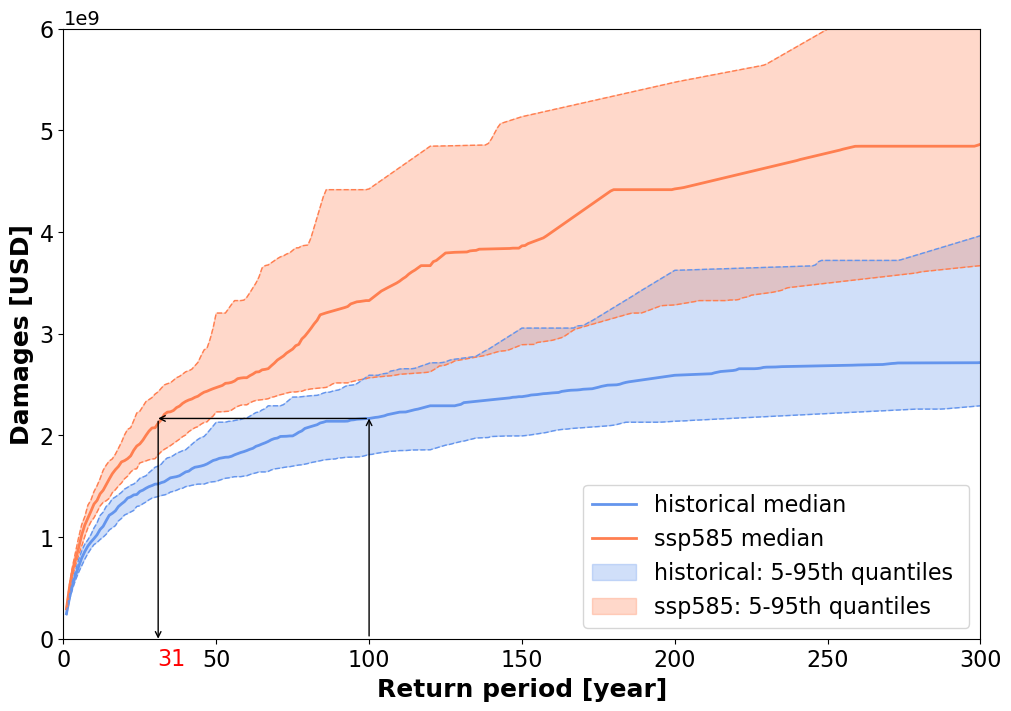

In [56]:
##Plotting
#plotting params
stt = '' #title
axttsize = 16
axlabsize=16
legttsize=12
stats = [0.05,0.5,0.95] #quantiles of the booststrapped distribution to highlight
qt_label =  ": "+format(100*stats[0],'.0f')+"-"+format(100*stats[-1],'.0f')+"th quantiles "
medxp = 100 #mark correspondance of past RP event in the future future

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

#initiate figure
fig = plt.figure(constrained_layout=True,figsize=(10,7))
axi = fig.subplots(nrows=1, ncols=1,sharex=False,sharey=False)


#compute stats
stat_dict_past = {}
stat_dict_fut = {}
for stat in stats:
    efcp_stat = np.quantile(efcs_past_stack,stat,axis=0)
    efcf_stat = np.quantile(efcs_fut_stack,stat,axis=0)
    stat_dict_past[stat] = efcp_stat
    stat_dict_fut[stat] = efcf_stat
    if stat== 0.5:
        ls = "solid"
        lw = 2
        labelp = pastname+' median'
        labelf = futname+' median'
        medyp = efcp_stat[medxp-1]
        prec = 1E8
        #medxf = np.where((efcf_stat > medyp-prec) & (efcf_stat < medyp+prec ))[0][0]
        medxf = np.where(efcf_stat==find_nearest(efcf_stat, medyp))[0][0]
        medyf = efcf_stat[medxf]
    else:
        ls = 'dashed'
        lw = 1
        labelp = None
        labelf = None

    axi.plot(rps,efcp_stat,color="cornflowerblue",linewidth=lw,linestyle=ls,label=labelp)
    axi.plot(rps,efcf_stat,color="coral",linewidth=lw,linestyle=ls,label=labelf)

axi.fill_between(rps, stat_dict_past[stats[0]],stat_dict_past[stats[-1]],color="cornflowerblue",alpha=0.3,label=pastname+qt_label)
axi.fill_between(rps, stat_dict_fut[stats[0]],stat_dict_fut[stats[-1]],color="coral",alpha=0.3,label=futname+qt_label)

#annotate

axi.annotate("",
            xy=(medxp, medyp), xycoords='data',
            xytext=(medxp, 0), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            color="black",
                            patchB=None,
                            shrinkB=0,
                            ),
            )
axi.annotate("",
            xy=(medxf, medyp), xycoords='data',
            xytext=(medxp, medyp), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            color="black",
                            patchB=None,
                            shrinkB=0,
                            ),
            )

axi.annotate("",
            xy=(medxf, 0), xycoords='data',
            xytext=(medxf, medyp), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            color="black",
                            patchB=None,
                            shrinkB=0,
                            ),
            )
axi.annotate(str(medxf),
            xy=(medxf, 0), xycoords='data',
            xytext=(medxf-0.18, -2.6E8), textcoords='data',
             fontsize=16, color='red'
            )
##title and legends
axi.set_title(stt,loc='left',fontsize=axttsize,fontweight='bold')
axi.legend()#fontsize=legttsize
pos_yoft = list(axi.yaxis.get_offset_text().get_position())
new_pos = pos_yoft.copy()
new_pos[0] = 0.0
new_pos[1] = 1
axi.yaxis.get_offset_text().set_position(new_pos)
axi.yaxis.get_offset_text().set_fontsize(14)
axi.set_xlabel("Return period [year]")#,fontsize=axlabsize,fontweight='bold'
axi.set_ylabel("Damages [USD]")#,fontsize=axlabsize,fontweight='bold'
axi.set_xlim([0,rp_max/2])
axi.set_ylim([0,6E9])
axi.tick_params(axis='both', labelsize=axlabsize)
